In [1]:
!pip install kora -q
from kora import drive
drive.link_nbs()

In [2]:
import utils

importing Jupyter notebook from /nbs/utils.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from keras.applications.efficientnet import EfficientNetB0
from keras.models import Model, Sequential
from keras.layers import TimeDistributed, Input, MaxPooling3D, LSTM, Dense, Conv3D, Conv2D, BatchNormalization, Flatten, Dropout, Convolution2D, Activation, MaxPooling2D, GlobalAveragePooling2D, concatenate, Reshape
from keras import losses
from tensorflow import keras

In [4]:
""" GLOBAL VARIABLES """
NUM_CLASSES = 4
EPOCHS = 10
INSTACK = 16
IMG_SIZE = (224, 224)
LEN_TRAIN = 85

In [ ]:
""" Data loading """

train_gen = utils.joinedGens(Train=True, needDirectories=False)
val_gen = utils.joinedGens(Val=True)

In [6]:
TVHI_trained = "/content/drive/MyDrive/TFLNew"
OF_trained = "/content/drive/MyDrive/OF_model"

In [7]:
""" Small function to change layers with same names in TS model"""

def changeLayerNames(model, model_name):
  
  if model_name == "resnet_base": 
    for i in range(len(model.layers)):
      if "batch_normalization" in model.layers[i]._name:
        model.layers[i]._name = "BN_ResNet_"+str(i)
      if "conv2d" in model.layers[i]._name:
        model.layers[i]._name = "conv2d_ResNet_"+str(i)



In [13]:
""" Building Model """

def build_TS_model():

  
  #Load resnet base
  resnet_base = keras.models.load_model(TVHI_trained)
  changeLayerNames(resnet_base, "resnet_base") #process layers with same name


  BaseResNet = Model(resnet_base.inputs, resnet_base.layers[-8].output, name='resnet_base')
  BaseResNet.trainable = False #set the trained model to untrainable
  BaseResNet.summary()

  #Load OF model
  of_base = keras.models.load_model(OF_trained)
  b_inputs = of_base.inputs
  b_outputs = of_base.layers[-9].output
  x = Reshape((14, 14, 128))(b_outputs) #Add layer that reshapes the input from (None, 1, 14, 14, 128) to (None, 14, 14, 128) to make concatenation possible between TVHI frame model and OF model
  OF_Base = Model(b_inputs, x, name='of_base')
  OF_Base.trainable = False #set to untrainable
  OF_Base.summary()
  

  x = concatenate([OF_Base.output, BaseResNet.output]) #concatenate the two layers

  x = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation = 'relu')(x) #One shared 2D convolutional layer
  x = BatchNormalization(name="BN1")(x)
  x = MaxPooling2D(pool_size=(2,2), strides=2)(x)
  
  x = Flatten()(x)
  x = Dense(256, activation = 'relu')(x)
  x = BatchNormalization(name="BN2")(x)
  x = Dropout(0.2, name="DO_1")(x)

  x = Dense(64, activation='relu')(x)
  x = BatchNormalization(name="BN3")(x)
  x = Dropout(0.2, name = "DO_2")(x)
  
  x = Dense(NUM_CLASSES, activation='softmax')(x)

  model = keras.Model(
      inputs=[OF_Base.input, BaseResNet.input], outputs=x) #Double inputs
  model.compile(loss= keras.losses.SparseCategoricalCrossentropy(), optimizer='Adam', metrics=['accuracy'])
  model.summary()

  return model 


In [14]:
#Build model
ts_model = build_TS_model() 

Model: "resnet_base"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_ResNet_1 (Conv2D)       (None, 224, 224, 16  448         ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 tf.nn.relu_126 (TFOpLambda)    (None, 224, 224, 16  0           ['conv2d_ResNet_1[0][0]']        
                                )                                                       

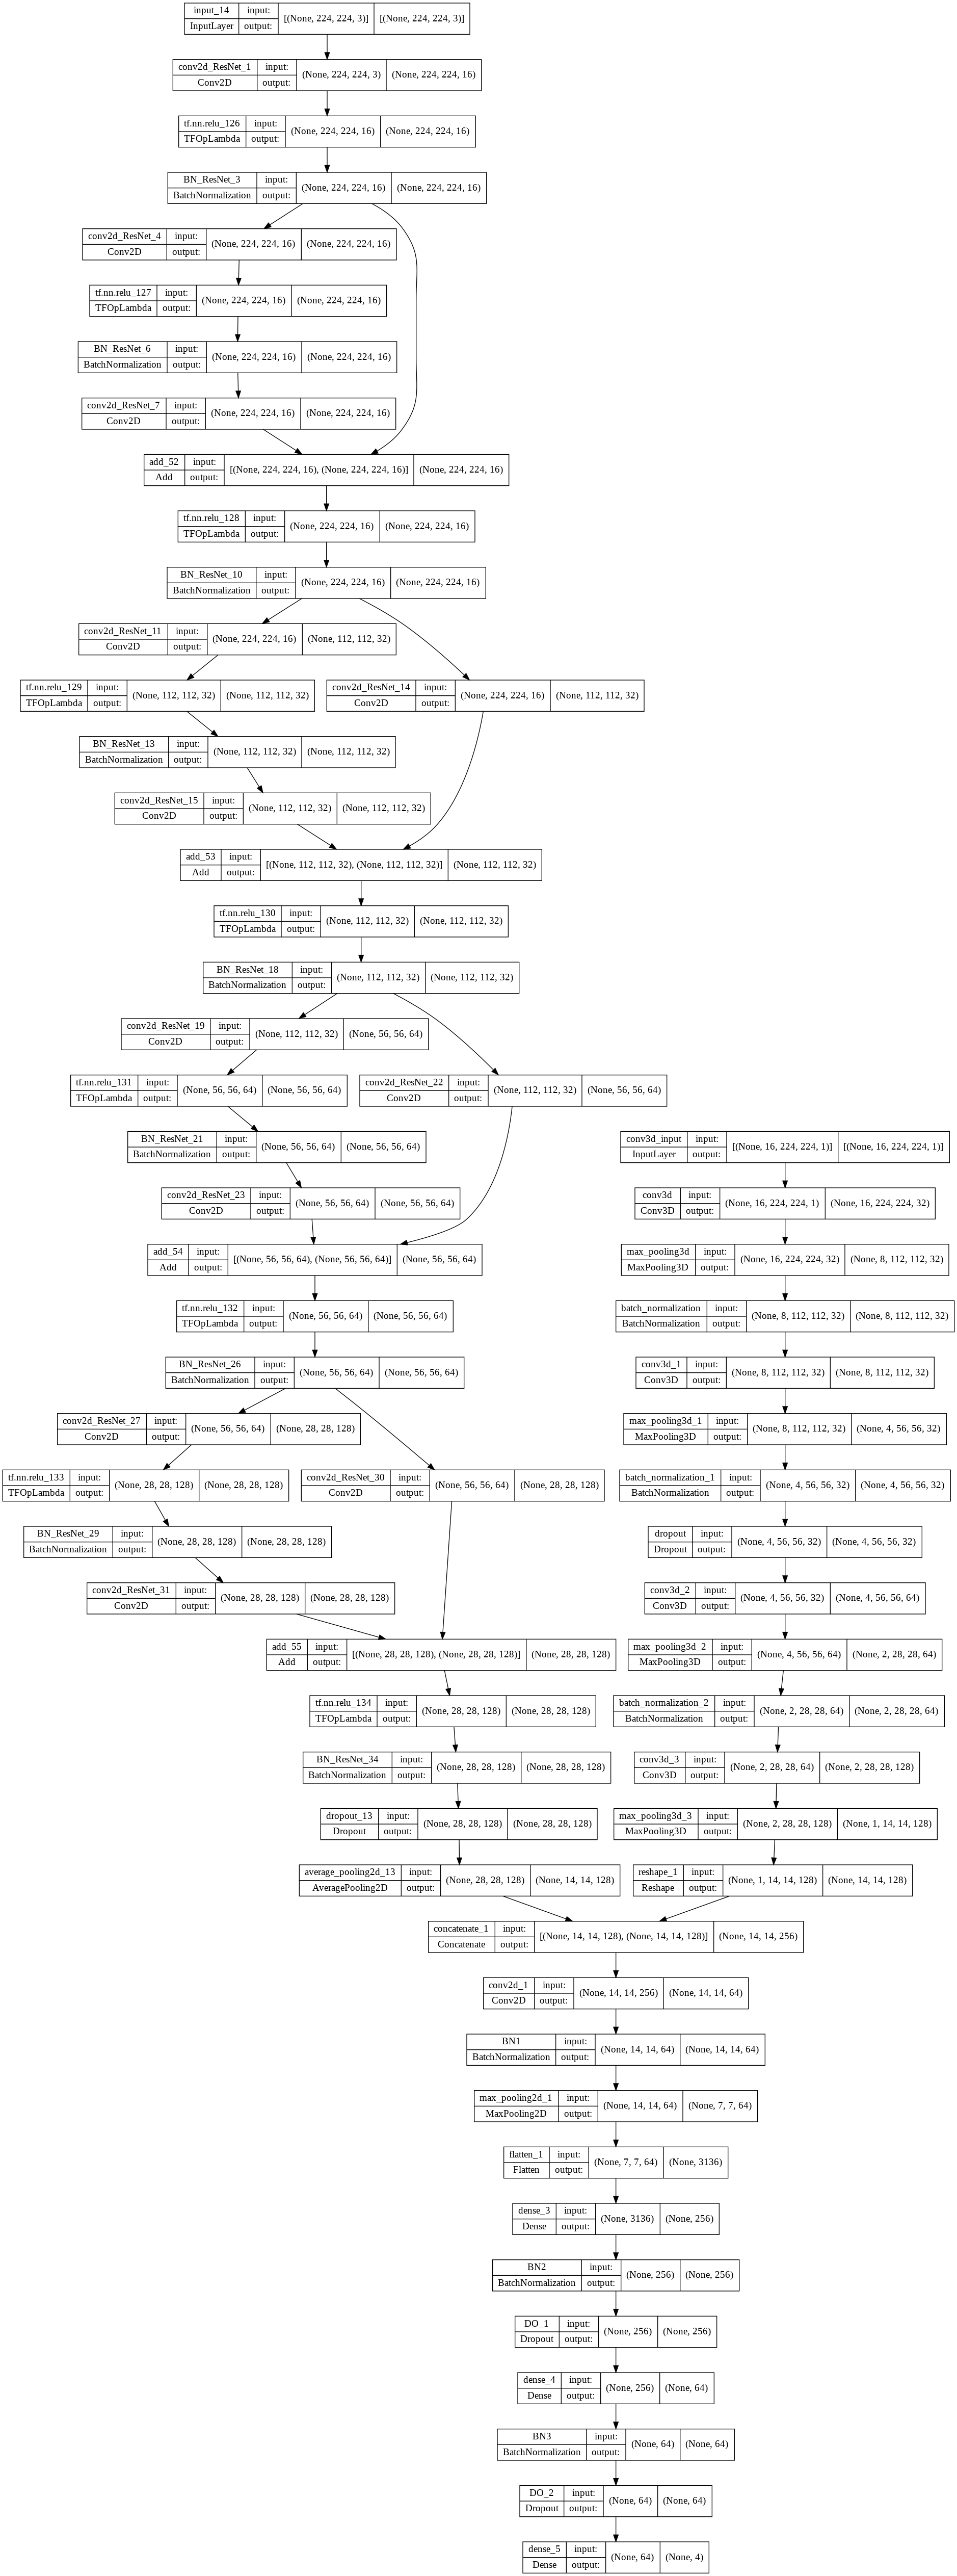

In [15]:
""" Plot the model """
keras.utils.plot_model(ts_model, "multi_input_and_output_model.png", show_shapes=True)

In [16]:
""" Set up callback and perform training """
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

ts_history = ts_model.fit(train_gen,epochs= EPOCHS, steps_per_epoch = LEN_TRAIN, validation_data=val_gen, validation_steps=15, callbacks= callback, verbose=1)

Epoch 1/10


InvalidArgumentError: ignored

In [ ]:
""" Plotting results """
utils.plotAccuracy("Accuracy Optical Flow model", ts_history.history['accuracy'], ts_history.history['val_accuracy'])
utils.plotLoss("Loss Optical Flow model", ts_history.history['loss'], ts_history.history['val_loss'])

In [ ]:
""" Save model and weights """
ts_model.save_weights('TS_weights.h5')
ts_model.save("TS_model", save_format = 'tf', include_optimizer=True)